In [6]:
import pandas as pd
import os

from utils import load_share_from_checkpoint
from benchmarks import create_categorical_variable_dict, categorical_variables_per_dataset, load_df
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import KFold, ParameterGrid, ParameterSampler, StratifiedKFold, train_test_split, StratifiedShuffleSplit, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import check_random_state

from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN

import torch

In [2]:
def get_preprocessed_data(dataset_name,task):
    dataset = load_df(dataset_name,task)
    X = dataset.drop(columns=['target'])
    y = dataset[['target']]

    categorical_variables = categorical_variables_per_dataset[dataset_name]
    is_cat = np.array([i in categorical_variables for i in range(len(X.columns))])

    cat_cols = X.columns.values[is_cat]
    num_cols = X.columns.values[~is_cat]

    categories = []
    for i in categorical_variables:
        uniques = list(X.iloc[:,i].unique())
        categories.append(sorted(uniques))
    
    cat_pipe = Pipeline([('ordinal', OrdinalEncoder(categories=categories))])
    num_pipe = Pipeline([('std',StandardScaler())])
    transformers = [
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
    ct = ColumnTransformer(transformers=transformers)
    
    processing = Pipeline([
        ('ct',ct),
    ])

    if task == 'classification':
        # Identity transformer for classification
        y_scaler = FunctionTransformer(lambda x: x.values)
    else:
        y_scaler = StandardScaler()

    X = processing.fit_transform(X)
    y = y_scaler.fit_transform(y)[:,0]

    return X,y

In [3]:
cv_results = {
    'boston' : {
        'ebm': 'boston_ExplainableBoostingRegressor_20230318-131322.csv',
        'emb_no_interactions': 'boston_ExplainableBoostingRegressor_20230318-131426.csv',
        'xgb': 'boston_XGBRegressor_20230318-131321.csv',
        'share': 'boston_SymbolicRegressor_20230316-115911.csv',
        'lr': 'boston_LinearRegression_20230318-131321.csv',
        'pygam':'boston_pygam_20230318-133816.csv'
    },
    'concrete': {
        'ebm': 'concrete_ExplainableBoostingRegressor_20230318-131431.csv',
        'emb_no_interactions': 'concrete_ExplainableBoostingRegressor_20230318-131538.csv',
        'xgb': 'concrete_XGBRegressor_20230318-131430.csv',
        'share': 'concrete_SymbolicRegressor_20230317-112945.csv',
        'lr': 'concrete_LinearRegression_20230318-131430.csv',
        'pygam': 'concrete_pygam_20230318-141517.csv'
    },
    'servo': {
        'ebm': 'servo_ExplainableBoostingRegressor_20230318-131542.csv',
        'emb_no_interactions': 'servo_ExplainableBoostingRegressor_20230318-131548.csv',
        'xgb': 'servo_XGBRegressor_20230318-131541.csv',
        'share': 'servo_SymbolicRegressor_20230316-171504.csv',
        'lr': 'servo_LinearRegression_20230318-131541.csv',
        'pygam': 'servo_pygam_20230318-141744.csv'
    },
}

In [3]:
for dataset, results in cv_results.items():
    for model, path in results.items():
        df_results = pd.read_csv(os.path.join('results', path))
        mean = df_results['score'].mean()
        std = df_results['score'].std()
        print(f"{dataset} {model} {mean} ({std})")

boston ebm 0.838380002280662 (0.0582215751063125)
boston emb_no_interactions 0.8120105517645098 (0.06423958677053226)
boston xgb 0.8785616548088674 (0.047752129342240504)
boston share 0.8395454734274018 (0.07315308112834058)
boston lr 0.7105491227005961 (0.07223996802428445)
boston pygam 0.8146952451279462 (0.05378154916984024)
concrete ebm 0.9278696240449748 (0.013470446432437558)
concrete emb_no_interactions 0.9006265768969156 (0.015152844786142821)
concrete xgb 0.9287552199428959 (0.018323867227182506)
concrete share 0.8899628844450994 (0.018441071686402785)
concrete lr 0.5930399274878513 (0.06754456352903841)
concrete pygam 0.8767215712016002 (0.019334134207915313)
servo ebm 0.6083138952963476 (0.5880806508317987)
servo emb_no_interactions -0.013329021707178257 (2.022645751479849)
servo xgb 0.8216222800899728 (0.2525473092759841)
servo share 0.6734852522599261 (0.29183682519678417)
servo lr -0.13509544203521623 (1.5444377865085126)
servo pygam 0.05558366465899783 (1.808809647992411

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



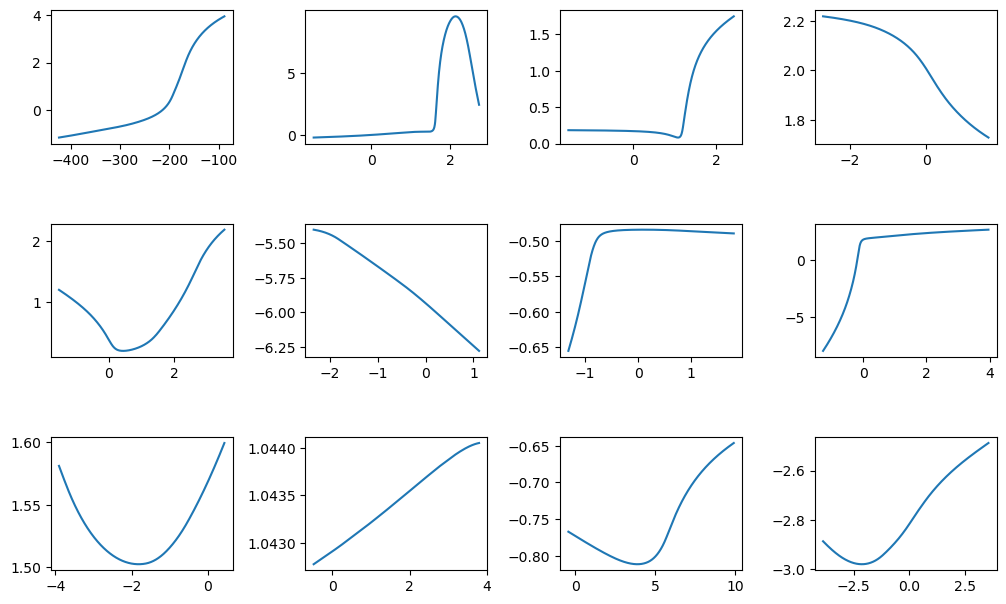

In [62]:
# Read the dictionaries
datasets = ['boston', 'concrete']

dataset = 'boston'

path = cv_results[dataset]['share']
df_results = pd.read_csv(os.path.join('results', path))
timestamp = df_results['timestamp'].iloc[0]
df_dict = pd.read_csv(os.path.join('checkpoints', timestamp, 'dictionary.csv'))

# Count the number of times the word 'shape' appears in the equation
df_dict['n_shape'] = df_dict['equation'].apply(lambda x: x.count('shape'))

# Count the number of variables in the equations
df_dict['n_variables'] = df_dict['equation'].apply(lambda x: x.count('X'))

eq1 = df_dict.sort_values('r2', ascending=False).iloc[0]

categorical_variable_dict = create_categorical_variable_dict('boston','regression')
esr = load_share_from_checkpoint(timestamp, eq1['equation'], checkpoint_dir='checkpoints', task='regression',n_features=13,equation_id=eq1['id'], categorical_variables_dict=categorical_variable_dict)
X,y = get_preprocessed_data('boston','regression')
shape_ranges = esr.get_shape_ranges(X)

fig, axs = plt.subplots(3, 4, figsize=(11, 7))
axs = axs.flatten()
esr._program.plot_shape_functions_given_ranges(shape_ranges, axs)
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.9, wspace=0.4, hspace=0.6)

In [8]:
str(esr._program)

'shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))'

In [20]:
import sympy

In [29]:
def number_shapes(program_str):
    start = 0
    counter = 0
    while True:
        start = program_str.find('shape', start)
        if start == -1:
            break
        program_str = program_str[:start] + f"shape{counter}" + program_str[start+5:]
        counter += 1
        start += 5
    return program_str

def extract_representation(gp, num_variables=15, num_shapes=15):
    sympy_mappings = {
    "div": lambda x, y: x / y,
    "mul": lambda x, y: x * y,
    "add": lambda x, y: x + y,
    "sub": lambda x, y: x - y,
    }
    for i in range(num_variables):
        sympy_mappings[f'X{i}'] = sympy.Symbol(f'x{i}')
    for i in range(num_shapes):
        sympy_mappings[f'shape{i}'] = sympy.Function(f's{i}')
        
    program_str = str(gp._program)
    program_str = number_shapes(program_str)
    sympy_program = sympy.sympify(program_str, locals=sympy_mappings)
    
    # splines_dict = {}
    # ranges_dict = {}
    # model = gp._program.model
    # for key in model.all_knots_dict.keys():
    #     params = model.all_params_dict[key]
    #     knots = model.all_knots_dict[key]
    #     splines_dict[key] = BSpline(knots,params.detach().numpy(),model.k)
    #     ranges_dict[key] =  (knots[0],knots[-1])
        
    return sympy_program
    

In [30]:
pr = extract_representation(esr)
pr

s0((((s1(x5) + s2(x4))*s4(x12)/(s3(x10)*s5(x1)) + s6(x7))/s7(x9) + s8(x8))*s10(x11)*s11(x3)*s13(x6)*s9(x0)/s12(x2))

In [24]:
sympy.latex(pr)

'S_{0}{\\left(\\frac{\\left(\\frac{\\frac{\\left(S_{1}{\\left(X_{5} \\right)} + S_{2}{\\left(X_{4} \\right)}\\right) S_{4}{\\left(X_{12} \\right)}}{S_{3}{\\left(X_{10} \\right)} S_{5}{\\left(X_{1} \\right)}} + S_{6}{\\left(X_{7} \\right)}}{S_{7}{\\left(X_{9} \\right)}} + S_{8}{\\left(X_{8} \\right)}\\right) S_{10}{\\left(X_{11} \\right)} S_{11}{\\left(X_{3} \\right)} S_{13}{\\left(X_{6} \\right)} S_{9}{\\left(X_{0} \\right)}}{S_{12}{\\left(X_{2} \\right)}} \\right)}'

In [ ]:
df_dict.groupby('n_shape')['r2'].max()

n_shape
1     0.562343
2     0.699373
3     0.673055
4     0.778916
5     0.851887
6     0.857196
7     0.841764
8     0.868286
9     0.893482
10    0.878283
11    0.889456
12    0.930128
13    0.919969
14    0.935789
15    0.931274
16    0.916370
17    0.826226
18    0.860018
19    0.779168
Name: r2, dtype: float64

In [6]:
def plot_ebm(axs,ebm_global, i, offset=0):
    ax = axs[i]
    shape_data = ebm_global.data(i+offset)
    x_values = shape_data['names']
    y_values = shape_data['scores']
    # if len(x_values) == len(y_values) + 1:
    #     x_values = x_values[:-1]
    ax.plot(x_values[:-1],y_values)

from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show
from benchmarks import run_experiment

In [10]:
ebm = ExplainableBoostingRegressor()
dataset = 'boston'
_m, _s, ebm = run_experiment(dataset, ebm, None, 'regression', 42, return_model=True, disable_ohe=False)
ebm_global = ebm.explain_global()

0it [00:00, ?it/s]c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
1it [00:04,  4.99s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2it [00:07,  3.47s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
3it [00:12,  4.02s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
4it [00:17,  4.73s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
5it [00:20,  4.12s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824, 0.8268518576184647]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
6it [00:28,  5.21s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824, 0.8268518576184647, 0.9165466918018259]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
7it [00:32,  4.93s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824, 0.8268518576184647, 0.9165466918018259, 0.8705582018244653]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
8it [00:44,  7.08s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824, 0.8268518576184647, 0.9165466918018259, 0.8705582018244653, 0.792787700635024]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
9it [00:49,  6.37s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824, 0.8268518576184647, 0.9165466918018259, 0.8705582018244653, 0.792787700635024, 0.8134533404198507]


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
10it [00:53,  5.30s/it]

ExplainableBoostingRegressor() | score: <function score at 0x000001F68C0C1310>
[0.9003719194746254, 0.7441326003543507, 0.8134391223949213, 0.7946733756694824, 0.8268518576184647, 0.9165466918018259, 0.8705582018244653, 0.792787700635024, 0.8134533404198507, 0.9109852126136091]


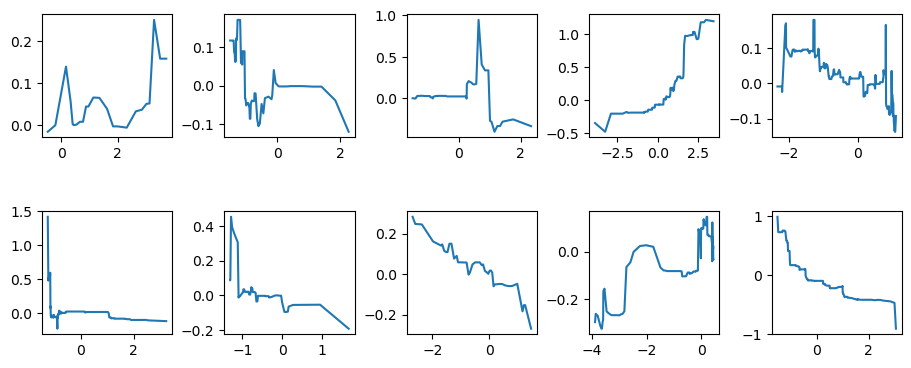

In [64]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()
for i in range(10):
    plot_ebm(axs,ebm_global, i, offset=12)
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.9, wspace=0.4, hspace=0.6)

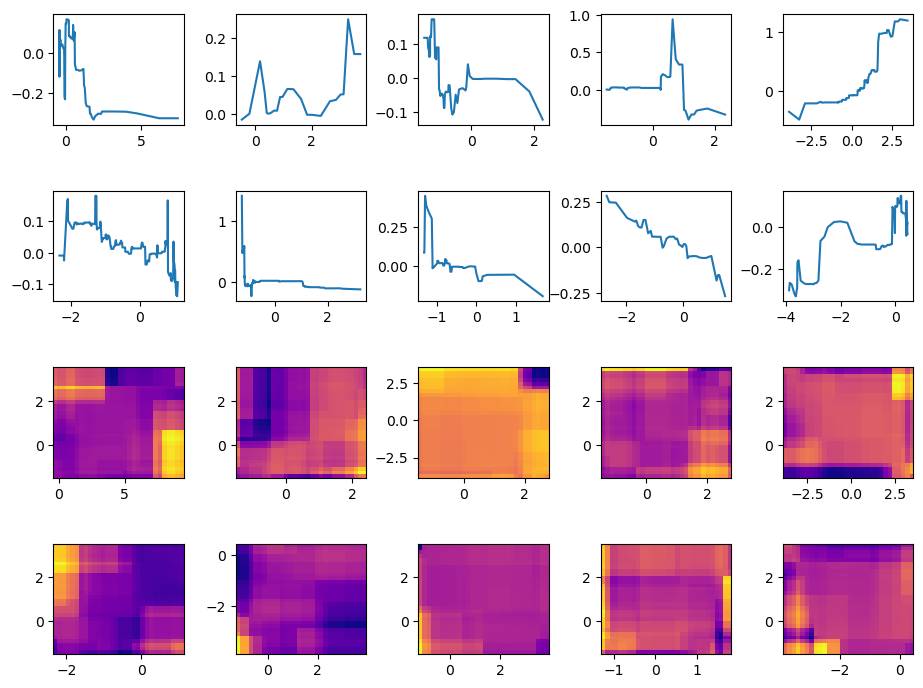

In [18]:
def plot_heatmap(axs, ebm_global, i, offfset=0):
    data = ebm_global.data(i+offfset)
    ax = axs[i]
    # print(data)
    im = ax.imshow(data['scores'].T, extent=[data['left_names'][0], data['left_names'][-1],data['right_names'][0], data['right_names'][-1]], origin='lower', aspect='auto', cmap='plasma')
    # ax.set_xlabel(r'$E$ (cal)', fontsize=label_fontsize)
    # ax.set_ylabel('$m$ (g)', fontsize=label_fontsize)
    # ax.set_xticks([500,1500,2500])
    # ax.set_xticklabels([500,1500,2500])
    # ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    return im


fig, axs = plt.subplots(4, 5, figsize=(10, 8))
axs = axs.flatten()
for i in range(10):
    plot_ebm(axs,ebm_global, i, offset=11)
for i in range(10,20):
    im = plot_heatmap(axs, ebm_global, i, offfset=12)
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.9, wspace=0.4, hspace=0.6)

# # handles, labels = axs[0][2].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', fontsize=20)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.85, wspace=0.5, hspace=0.4)
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
# cbar_ax.tick_params(axis='both', which='major')
# fig.colorbar(im, cax=cbar_ax)

In [12]:
show(ebm_global)

<!-- http://127.0.0.1:7001/2158448117216/ -->

In [ ]:
def get_preprocessed_data_2(dataset_name,task):
    dataset = load_df(dataset_name,task)
    X = dataset.drop(columns=['target'])
    y = dataset[['target']]

    categorical_variables = categorical_variables_per_dataset[dataset_name]
    is_cat = np.array([i in categorical_variables for i in range(len(X.columns))])

    cat_cols = X.columns.values[is_cat]
    num_cols = X.columns.values[~is_cat]

    categories = []
    for i in categorical_variables:
        uniques = list(X.iloc[:,i].unique())
        categories.append(sorted(uniques))
    
    cat_pipe = Pipeline([('ordinal', OrdinalEncoder(categories=categories))])
    num_pipe = Pipeline([('std',StandardScaler())])
    transformers = [
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
    ct = ColumnTransformer(transformers=transformers)
    
    processing = Pipeline([
        ('ct',ct),
    ])

    if task == 'classification':
        # Identity transformer for classification
        y_scaler = FunctionTransformer(lambda x: x.values)
    else:
        y_scaler = StandardScaler()

    X = processing.fit_transform(X)
    y = y_scaler.fit_transform(y)[:,0]

    return X,y

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


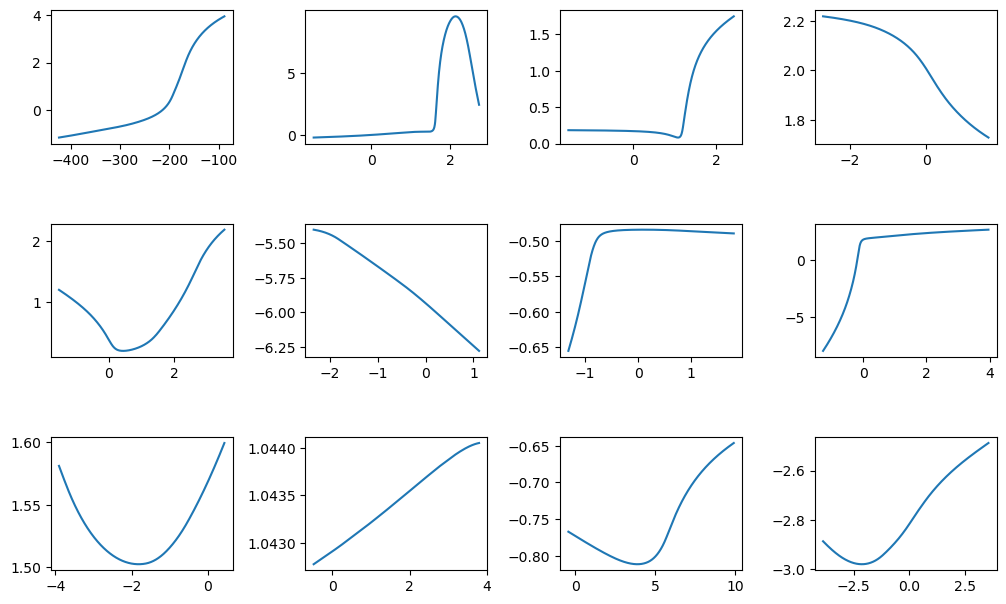

In [4]:
datasets = ['boston', 'concrete']

dataset = 'boston'

path = cv_results[dataset]['share']
df_results = pd.read_csv(os.path.join('results', path))
timestamp = df_results['timestamp'].iloc[0]
df_dict = pd.read_csv(os.path.join('checkpoints', timestamp, 'dictionary.csv'))

# Count the number of times the word 'shape' appears in the equation
df_dict['n_shape'] = df_dict['equation'].apply(lambda x: x.count('shape'))

# Count the number of variables in the equations
df_dict['n_variables'] = df_dict['equation'].apply(lambda x: x.count('X'))

eq1 = df_dict.sort_values('r2', ascending=False).iloc[0]

categorical_variable_dict = create_categorical_variable_dict('boston','regression')
esr = load_share_from_checkpoint(timestamp, eq1['equation'], checkpoint_dir='checkpoints', task='regression',n_features=13,equation_id=eq1['id'], categorical_variables_dict=categorical_variable_dict)
X,y = get_preprocessed_data('boston','regression')
shape_ranges = esr.get_shape_ranges(X)

fig, axs = plt.subplots(3, 4, figsize=(11, 7))
axs = axs.flatten()
esr._program.plot_shape_functions_given_ranges(shape_ranges, axs)
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.9, wspace=0.4, hspace=0.6)



2023-03-16T11.59.15


In [4]:
def get_preprocessed_data_exactly(dataset_name,task,random_state=42):

    random_state = check_random_state(random_state)
    
    dataset = load_df(dataset_name,task)
    X = dataset.drop(columns=['target'])
    y = dataset[['target']]

    if task == 'classification':
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.09, random_state=random_state)
        train_index, val_index = next(sss.split(X,y))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    elif task == 'regression':
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.09, random_state=random_state)

    categorical_variables = categorical_variables_per_dataset[dataset_name]
    is_cat = np.array([i in categorical_variables for i in range(len(X.columns))])

    cat_cols = X.columns.values[is_cat]
    num_cols = X.columns.values[~is_cat]

    categories = []
    for i in categorical_variables:
        uniques = list(X.iloc[:,i].unique())
        categories.append(sorted(uniques))
    
    cat_pipe = Pipeline([('ordinal', OrdinalEncoder(categories=categories))])
    num_pipe = Pipeline([('std',StandardScaler())])
    transformers = [
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
    ct = ColumnTransformer(transformers=transformers)
    
    processing = Pipeline([
        ('ct',ct),
    ])

    if task == 'classification':
        # Identity transformer for classification
        y_scaler = FunctionTransformer(lambda x: x.values)
    else:
        y_scaler = StandardScaler()

    if task == 'classification':
        splitter = StratifiedKFold(n_splits=10,shuffle=True,random_state=random_state)
    else:
        splitter = KFold(n_splits=10,shuffle=True,random_state=random_state)

    for i, (train_index, test_index) in enumerate(splitter.split(X_train,y_train)):

        
        X_cv_train, y_cv_train = X_train.iloc[train_index], y_train.iloc[train_index]
        X_cv_test, y_cv_test = X_train.iloc[test_index], y_train.iloc[test_index]

        X_cv_train = processing.fit_transform(X_cv_train)
        y_cv_train = y_scaler.fit_transform(y_cv_train)[:,0]

        X_cv_test = processing.transform(X_cv_test)
        y_cv_test = y_scaler.transform(y_cv_test)[:,0]

        return X_cv_train, X_cv_test, y_cv_train, y_cv_test

In [5]:
def load_esr():
        dataset = 'boston'

        path = cv_results[dataset]['share']
        df_results = pd.read_csv(os.path.join('results', path))
        timestamp = df_results['timestamp'].iloc[0]
        df_dict = pd.read_csv(os.path.join('checkpoints', timestamp, 'dictionary.csv'))

        # Count the number of times the word 'shape' appears in the equation
        df_dict['n_shape'] = df_dict['equation'].apply(lambda x: x.count('shape'))

        # Count the number of variables in the equations
        df_dict['n_variables'] = df_dict['equation'].apply(lambda x: x.count('X'))

        eq1 = df_dict.sort_values('r2', ascending=False).iloc[0]

        categorical_variable_dict = create_categorical_variable_dict('boston','regression')
        esr = load_share_from_checkpoint(timestamp, eq1['equation'], checkpoint_dir='checkpoints', task='regression',n_features=13,equation_id=eq1['id'], categorical_variables_dict=categorical_variable_dict)
        return esr


In [ ]:
esr = load_esr()
program = esr._program
timestamp_new = datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
program.timestamp = timestamp_new
program.optim_dict['keep_models'] = True
program.optim_dict['constructor_dict'] = {
        'n_hidden_layers':5,
        'width':10,
        'activation_name':'ReLU'
        }
print(timestamp_new)
device = 'cpu'
X, _, y, _ = get_preprocessed_data_exactly('boston','regression')
ohe_matrices = esr._create_ohe_matrices(X,esr.categorical_variables, device=esr.optim_dict['device'])
X = torch.from_numpy(np.array(X)).float().to(esr.optim_dict['device'])
y = torch.from_numpy(np.array(y)).float().to(esr.optim_dict['device'])
sample_weights = np.ones(len(y))
program.raw_fitness(X, y, sample_weights, ohe_matrices=ohe_matrices)

In [6]:
esr = load_esr()
program = esr._program
timestamp_new = datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
program.timestamp = timestamp_new
program.optim_dict['keep_models'] = True

from nam.config import defaults
from nam.models import FeatureNN

config = defaults()
config.regression=True

constructor_dict_FeatureNN = {
    'config':config,
    'name':'FeatureNN',
    'input_shape':1,
    'num_units':1024,
    'feature_num':0
}



program.optim_dict['constructor_dict'] = constructor_dict_FeatureNN
program.optim_dict['shape_class'] = FeatureNN
print(timestamp_new)
device = 'cpu'
X, _, y, _ = get_preprocessed_data_exactly('boston','regression')
ohe_matrices = esr._create_ohe_matrices(X,esr.categorical_variables, device=esr.optim_dict['device'])
X = torch.from_numpy(np.array(X)).float().to(esr.optim_dict['device'])
y = torch.from_numpy(np.array(y)).float().to(esr.optim_dict['device'])
sample_weights = np.ones(len(y))
program.raw_fitness(X, y, sample_weights, ohe_matrices=ohe_matrices)

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\krkac\Miniconda3\envs\share

2023-03-23T21.21.04
shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\trainer.py:1600: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_0a80cf28-fea8-43aa-992f-15bbbb0f499e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0a80cf28-fea8-43aa-992f-15bbbb0f499e.ckpt
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))
shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6))) | raw_fitness: 1.0000557197204747


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


1.0000557197204747

In [27]:
fn = FeatureNN(**constructor_dict_FeatureNN)


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\torch\nn\init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [9]:
from torch.nn import init
import math

class ExU(torch.nn.Module):

    def __init__(self,in_features,out_features):
        super(ExU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters()
    

    def forward(self, x):
        # return torch.clamp((x - self.bias).matmul(torch.exp(self.weights)),-1,1)
        return torch.clamp(torch.matmul(x-self.bias,torch.exp(self.weight)),0,1)
    
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        # init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # if self.bias is not None:
        #     fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        #     bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        #     init.uniform_(self.bias, -bound, bound)
        torch.nn.init.normal_(self.weight, mean=3.0, std=0.5)
        torch.nn.init.normal_(self.bias, std=0.5)

        

class ShapeNNExu(torch.nn.Module):

    def __init__(self, n_hidden_layers, width, activation_name='ReLU', exu_width=1024):
        super(ShapeNNExu, self).__init__()
        self.n_hidden_layers = n_hidden_layers
        self.width = width
        if activation_name == 'ReLU':
            activation = torch.nn.ReLU()
        elif activation_name == 'Sigmoid':
            activation = torch.nn.Sigmoid()
        elif activation_name == 'ELU':
            activation = torch.nn.ELU()
        self.batch_norm = torch.nn.BatchNorm1d(1)
        self.input_layer = ExU(1,exu_width)
        self.input_activation = activation
        self.hidden_layers = []
        self.hidden_layers.append(torch.nn.Linear(exu_width,self.width))
        self.hidden_layers.append(activation)
        for i in range(self.n_hidden_layers-1):
            self.hidden_layers.append(torch.nn.Linear(self.width,self.width))
            self.hidden_layers.append(activation)
        self.output_layer = torch.nn.Linear(self.width,1)
        self.nn = torch.nn.Sequential(self.batch_norm,self.input_layer, 
                                        self.input_activation,
                                        *self.hidden_layers,
                                        self.output_layer)
    def forward(self, x):
        return self.nn(x.unsqueeze(1))

In [150]:
esr = load_esr()
program = esr._program
timestamp_new = datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
program.timestamp = timestamp_new
program.optim_dict['keep_models'] = True

constructor_dict = {
    'n_hidden_layers':5,
    'width':10,
    'activation_name':'ReLU',
    'exu_width':1024,
}



program.optim_dict['constructor_dict'] = constructor_dict
program.optim_dict['shape_class'] = ShapeNNExu
print(timestamp_new)
device = 'cpu'
X, _, y, _ = get_preprocessed_data_exactly('boston','regression')
ohe_matrices = esr._create_ohe_matrices(X,esr.categorical_variables, device=esr.optim_dict['device'])
X = torch.from_numpy(np.array(X)).float().to(esr.optim_dict['device'])
y = torch.from_numpy(np.array(y)).float().to(esr.optim_dict['device'])
sample_weights = np.ones(len(y))
program.raw_fitness(X, y, sample_weights, ohe_matrices=ohe_matrices)

c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\krkac\Miniconda3\envs\share

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))
2023-03-23T23.04.06
shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\trainer.py:1600: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_cbf9df8f-d37e-4a6f-8a5f-98e529cef8b7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cbf9df8f-d37e-4a6f-8a5f-98e529cef8b7.ckpt
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))
shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6))) | raw_fitness: 0.838516388617247


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


0.838516388617247

In [7]:
esr = load_esr()
program = esr._program
timestamp_new = datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
program.timestamp = timestamp_new
program.optim_dict['keep_models'] = True
program.optim_dict['constructor_dict'] = {
        'n_hidden_layers':5,
        'width':10,
        'activation_name':'ELU'
        }
program.optim_dict['shape_class'] = ShapeNN
program.optim_dict['early_stopping_val_loss'] = False
print(timestamp_new)
device = 'cpu'
X, _, y, _ = get_preprocessed_data_exactly('boston','regression')
ohe_matrices = esr._create_ohe_matrices(X,esr.categorical_variables, device=esr.optim_dict['device'])
X = torch.from_numpy(np.array(X)).float().to(esr.optim_dict['device'])
y = torch.from_numpy(np.array(y)).float().to(esr.optim_dict['device'])
sample_weights = np.ones(len(y))
program.raw_fitness(X, y, sample_weights, ohe_matrices=ohe_matrices)

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))
2023-03-23T23.12.45
shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\krkac\Miniconda3\envs\share

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs\.lr_find_81436416-679b-43ad-b298-dd9e3ffa4dc4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_81436416-679b-43ad-b298-dd9e3ffa4dc4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1it [00:00, ?it/s]

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6))) | raw_fitness: 0.07767163829493763


0.07767163829493763

In [10]:
esr = load_esr()
program = esr._program
timestamp_new = datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
program.timestamp = timestamp_new
program.optim_dict['keep_models'] = True

constructor_dict = {
    'n_hidden_layers':5,
    'width':10,
    'activation_name':'ReLU',
    'exu_width':1024,
}


program.optim_dict['early_stopping_val_loss'] = False
program.optim_dict['constructor_dict'] = constructor_dict
program.optim_dict['shape_class'] = ShapeNNExu
print(timestamp_new)
device = 'cpu'
X, _, y, _ = get_preprocessed_data_exactly('boston','regression')
ohe_matrices = esr._create_ohe_matrices(X,esr.categorical_variables, device=esr.optim_dict['device'])
X = torch.from_numpy(np.array(X)).float().to(esr.optim_dict['device'])
y = torch.from_numpy(np.array(y)).float().to(esr.optim_dict['device'])
sample_weights = np.ones(len(y))
program.raw_fitness(X, y, sample_weights, ohe_matrices=ohe_matrices)

c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\krkac\Miniconda3\envs\share

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))
2023-03-23T23.15.53
shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_0af0d4fb-45f5-4113-a9cd-aa8dcabe4cc7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0af0d4fb-45f5-4113-a9cd-aa8dcabe4cc7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1it [00:00, ?it/s]

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6))) | raw_fitness: 0.9932285733202915


0.9932285733202915

shape(mul(div(mul(mul(mul(add(div(add(div(mul(div(add(shape(X5), shape(X4)), shape(X10)), shape(X12)), shape(X1)), shape(X7)), shape(X9)), shape(X8)), shape(X0)), shape(X11)), shape(X3)), shape(X2)), shape(X6)))


c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\krkac\Miniconda3\envs\share\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


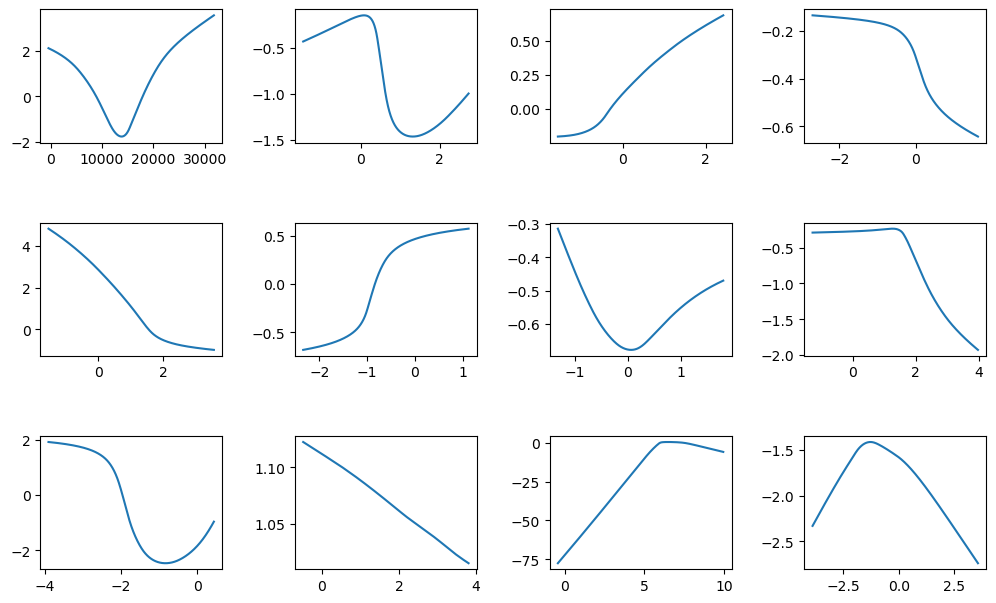

In [13]:
dataset = 'boston'

timestamp_dict = {
    'ELU': "2023-03-23T20.50.10",
    'ReLU': "2023-03-23T20.52.12",
    'EXU': "2023-03-23T21.08.59",
    'EXU2': "2023-03-23T21.21.04",
    "EXU_own": "2023-03-23T22.53.53",
    "no_early_stopping": "2023-03-23T23.12.45",
    "exu_no_early_stopping": "2023-03-23T23.15.53"
    }

from nam.config import defaults
from nam.models import FeatureNN

config = defaults()
config.regression=True

constructor_dict_FeatureNN = {
    'config':config,
    'name':'FeatureNN',
    'input_shape':1,
    'num_units':1024,
    'feature_num':0
}

constructor_dict = None
shape_class = None

# constructor_dict = constructor_dict_FeatureNN   
# shape_class = FeatureNN

# constructor_dict = {
#     'n_hidden_layers':5,
#     'width':10,
#     'activation_name':'ReLU',
#     'exu_width':1024
# }
# shape_class = ShapeNNExu

timestamp = timestamp_dict['ReLU']
df_dict = pd.read_csv(os.path.join('checkpoints', timestamp, 'dictionary.csv'))

# Count the number of times the word 'shape' appears in the equation
df_dict['n_shape'] = df_dict['equation'].apply(lambda x: x.count('shape'))

# Count the number of variables in the equations
df_dict['n_variables'] = df_dict['equation'].apply(lambda x: x.count('X'))

eq1 = df_dict.sort_values('r2', ascending=False).iloc[0]

categorical_variable_dict = create_categorical_variable_dict('boston','regression')
esr = load_share_from_checkpoint(timestamp, eq1['equation'], checkpoint_dir='checkpoints', task='regression',n_features=13,equation_id=eq1['id'], categorical_variables_dict=categorical_variable_dict, constructor_dict=constructor_dict, shape_class=shape_class)
X,y = get_preprocessed_data('boston','regression')
shape_ranges = esr.get_shape_ranges(X)

fig, axs = plt.subplots(3, 4, figsize=(11, 7))
axs = axs.flatten()
esr._program.plot_shape_functions_given_ranges(shape_ranges, axs,10000)
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.9, wspace=0.4, hspace=0.6)



In [11]:
timestamp_new

'2023-03-23T20.39.27'